In [1]:
from functools import partial
import os
import time

import matplotlib.pyplot as plt
import numpy as onp

from jax import jit, lax, random, vmap
import jax.numpy as np

import numpyro; numpyro.set_platform("cpu"); numpyro.set_host_device_count(4)
from numpyro.contrib.autoguide import AutoBNAFNormal, AutoContinuousELBO
import numpyro.distributions as dist
from numpyro.examples.datasets import COVTYPE, load_dataset
from numpyro.handlers import scale
from numpyro.infer.hmc_util import consensus, parametric_draws
from numpyro.infer.util import initialize_model, transformed_potential_energy
from numpyro.infer import MCMC, NUTS, SVI, predictive
import numpyro.optim as optim

### load data

In [2]:
def _load_dataset():
    _, fetch = load_dataset(COVTYPE, shuffle=False)
    features, labels = fetch()

    # normalize features and add intercept
    features = (features - features.mean(0)) / features.std(0)
    features = np.hstack([features, np.ones((features.shape[0], 1))])

    # make binary feature
    _, counts = onp.unique(labels, return_counts=True)
    specific_category = np.argmax(counts)
    labels = (labels == specific_category)

    N, dim = features.shape
    print("Data shape:", features.shape)
    print("Label distribution: {} has label 1, {} has label 0"
          .format(labels.sum(), N - labels.sum()))
    return features, labels

X_full, y_full = _load_dataset()

Data shape: (581012, 55)
Label distribution: 211840 has label 1, 369172 has label 0


In [3]:
def get_train_shards_and_test_data(X, y, K, N, rng=None):
    if rng is not None:
        idxs = random.shuffle(rng, np.arange(X.shape[0]))
        X = X[idxs]
        y = y[idxs]
    shards = []
    for i in range(K):
        shards.append((X[i * N: (i + 1) * N], y[i * N: (i + 1) * N]))
    train_data = (X[:K * N], y[:K * N])
    test_data = (X[K * N:], y[K * N:])
    return shards, train_data, test_data

K, N = 40, 10000
shards, (X_train, y_train), (X_test, y_test) = get_train_shards_and_test_data(
    X_full, y_full, K, N, random.PRNGKey(0))
print("Train set contains {} ({}%) data points.".format(
    K * N, round(K * N / X_full.shape[0] * 100, 2)))
print("Test set contains {} ({}%) data points.".format(
    X_full.shape[0] - K * N, round(100 - K * N / X_full.shape[0] * 100, 2)))

Train set contains 400000 (68.85%) data points.
Test set contains 181012 (31.15%) data points.


### model

In [4]:
def model(X, y=None, prior_scale=1, likelihood_scale=1):
    with scale(scale_factor=prior_scale):
        coefs = numpyro.sample('coefs', dist.Normal(0, 1), sample_shape=X.shape[-1:])
    with scale(scale_factor=likelihood_scale):
        numpyro.sample('y', dist.Bernoulli(logits=np.dot(X, coefs)), obs=y)

### sampling

In [6]:
def get_subposterior(rng, shard, K):
    X, y = shard
    mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2500, num_chains=4,
                chain_method="parallel", progress_bar=False)
    mcmc.run(rng, X, y, prior_scale=1 / K)
    return mcmc.get_samples()

In [7]:
rngs = random.split(random.PRNGKey(0), K)
subposteriors = []
for i, (rng, shard) in enumerate(zip(rngs, shards)):
    start = time.time()
    sep = '=' * 31
    if i > 5:
        break
    print('\n ' + sep + ' SUBPOSTERIOR {:02d} '.format(i) + sep, end='')
    samples = get_subposterior(rng, shard, K)
    if not os.path.exists('.results'):
        os.makedirs('.results')
    np.save('.results/subposterior_{:02d}.npy'.format(i), samples)
    subposteriors.append(samples)
    end = time.time()
    print("Elapsed time:", end - start)


 =============================== SUBPOSTERIOR 00 ===============================took 71.48939394950867

 =============================== SUBPOSTERIOR 01 ===============================

KeyboardInterrupt: 

### merge subposteriors

In [8]:
consensus_samples = consensus(subposteriors, 10000)
parametric_samples = parametric_draws(subposteriors, 10000)
np.save('.results/consensus_samples.npy', consensus_samples)
np.save('.results/parametric_samples.npy', parametric_samples)

In [11]:
y_consensus = predictive(random.PRNGKey(0), model, consensus_samples, X_test)
y_consensus = (y_consensus.sum(axis=0) / y_consensus.shape[0]) >= 0.5
acc = (y_consensus == y_test).sum() / y_test.shape[0]
print('Consensus accuaracy: {}'.format(round(acc.item(), 4)))

y_parametric = predictive(random.PRNGKey(1), model, parametric_samples, X_test)
y_parametric = (y_parametric.sum(axis=0) / y_parametric.shape[0]) >= 0.5
acc = (y_parametric == y_test).sum() / y_test.shape[0]
print('Parametric accuaracy: {}'.format(round(acc.item(), 4)))

Consensus accuaracy: 0.771
Parametric accuaracy: 0.771


### train bnaf

In [15]:
batch_size = 1000
iters_per_epoch = X_train.shape[0] // batch_size
guide = AutoBNAFNormal(model, num_flows=1, hidden_factors=[8])
svi = SVI(model, guide, optim.Adam(0.01), AutoContinuousELBO(), likelihood_scale=iters_per_epoch)
svi_state = svi.init(random.PRNGKey(0), X_train[:1], y_train[:1])

def epoch_train(epoch, svi_state):
    idx = random.shuffle(random.fold_in(random.PRNGKey(1), epoch), np.arange(X_train.shape[0]))
    X, y = X_train[idx], y_train[idx]

    def body_fn(state, i):
        X_batch = lax.dynamic_slice_in_dim(X, i * batch_size, batch_size)
        y_batch = lax.dynamic_slice_in_dim(y, i * batch_size, batch_size)
        return svi.update(state, X_batch, y_batch)

    svi_state, losses = lax.scan(body_fn, svi_state, np.arange(iters_per_epoch))
    return svi_state, losses

In [14]:
losses = np.array([])
num_epochs = 2
for epoch in range(1, num_epochs + 1):
    tic = time.time()
    svi_state, epoch_loss = epoch_train(epoch, svi_state)
    params = svi.get_params(svi_state)
    posterior = guide.sample_posterior(random.PRNGKey(2 * epoch), params, sample_shape=(10000,))
    y_iaf = predictive(random.PRNGKey(2 * epoch + 1), model, posterior, X_test)["y"]
    y_iaf = (y_iaf.sum(axis=0) / y_iaf.shape[0]) >= 0.5
    acc = (y_iaf == y_test).sum() / y_test.shape[0]
    print("Epoch {:02d} - loss {:.4f} - acc {} - time {}".format(
        epoch, np.mean(epoch_loss), round(acc.item(), 4), time.time() - tic))
    losses = np.concatenate([losses, epoch_loss])

Epoch 01 - loss 231555.4531 - acc 0.7705 - time 71.38712668418884


KeyboardInterrupt: 

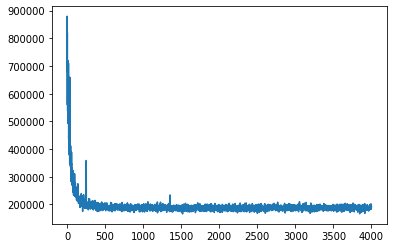

In [16]:
plt.plot(losses)

### Flow HMC

In [5]:
transform = guide.get_transform(opt_state)
unpack_fn = guide.unpack_latent
latent_size = guide.latent_size

NameError: name 'guide' is not defined

In [88]:
def make_transformed_pe(potential_fn, transform, unpack_fn, prior_scale):
    def transformed_potential_fn(z):
        u, intermediates = transform.call_with_intermediates(z)
        logdet = transform.log_abs_det_jacobian(z, u, intermediates=intermediates) * prior_scale
        return potential_fn(unpack_fn(u)) + logdet

    return transformed_potential_fn

In [79]:
def get_flow_subposterior(rng, shard, K):
    X, y = shard
    init_params = random.normal(rng, (4, latent_size))
    _, potential_fn, _ = initialize_model(rng, model, X, y, prior_scale=1 / K)
    transformed_potential_fn = make_transformed_pe(potential_fn, transform, unpack_fn, 1 / K)
    samples = mcmc(num_warmup=1000, num_samples=2500, init_params=init_params,
                   num_chains=4, potential_fn=transformed_potential_fn)
    return samples

In [89]:
init_params = random.normal(random.PRNGKey(1), (latent_size,))
_, potential_fn, _ = initialize_model(rng, model, X, y, prior_scale=1 / K)
transformed_potential_fn = make_transformed_pe(potential_fn, transform, unpack_fn, 1 / K)
samples = mcmc(num_warmup=1000, num_samples=2500, init_params=init_params,
               num_chains=1, potential_fn=transformed_potential_fn)

sample: 100%|██████████| 2500/2500 [07:29<00:00,  5.58it/s, 1023 steps of size 6.92e-05. acc. prob=0.88]




                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 Param:0[0]    -13.94      0.25    -14.01    -14.26    -13.50      6.02      1.01
 Param:0[1]      3.60      0.10      3.58      3.46      3.77      4.80      1.81
 Param:0[2]     -1.00      0.36     -1.06     -1.56     -0.42      4.99      1.35
 Param:0[3]     -5.20      0.33     -5.32     -5.57     -4.54      3.37      1.68
 Param:0[4]     -2.45      0.67     -2.45     -3.60     -1.51      2.59      2.69
 Param:0[5]      6.63      0.44      6.74      5.81      7.18      3.79      1.65
 Param:0[6]      0.34      0.57      0.30     -0.56      1.29      7.26      1.01
 Param:0[7]     -1.72      0.30     -1.72     -2.22     -1.24      4.35      1.86
 Param:0[8]     10.02      0.59      9.89      9.13     11.04      4.90      1.15
 Param:0[9]     -6.03      0.49     -5.89     -6.84     -5.33      3.51      1.69
Param:0[10]     11.40      0.53     11.44     10.59     12.21      3.57      2.19
Param:0[11]   

In [94]:
flow_samples = vmap(lambda x: unpack_fn(transform(x)))(samples)

In [82]:
from numpyro.diagnostics import summary

In [97]:
rngs = random.split(random.PRNGKey(2), 2500)
y_flow = vmap(partial(predict, model, X_test))(rngs, flow_samples)
y_flow = (y_flow.sum(axis=0) / y_flow.shape[0]) >= 0.5
acc = (y_flow == y_test).sum() / y_test.shape[0]
acc

DeviceArray(0.7682474, dtype=float32)

In [92]:
summary({'coefs': real_samples['coefs'][None, ...]})



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  coefs[0]      1.97      0.07      1.97      1.86      2.09     17.99      1.01
  coefs[1]     -0.02      0.02     -0.02     -0.05      0.02     21.80      1.02
  coefs[2]     -0.12      0.02     -0.12     -0.14     -0.08      8.34      1.05
  coefs[3]     -0.31      0.02     -0.31     -0.34     -0.28      7.72      1.17
  coefs[4]     -0.11      0.02     -0.11     -0.14     -0.08     10.66      1.01
  coefs[5]     -0.10      0.02     -0.09     -0.12     -0.07     65.96      1.00
  coefs[6]      0.01      0.02      0.01     -0.03      0.05      7.04      1.15
  coefs[7]     -0.49      0.03     -0.49     -0.53     -0.44     14.74      1.00
  coefs[8]      0.24      0.02      0.23      0.20      0.27      5.82      1.47
  coefs[9]     -0.01      0.01     -0.01     -0.03      0.02      6.66      1.48
 coefs[10]      1.67      0.04      1.68      1.61      1.74      6.33      1.03
 coefs[11]      0.53      

In [52]:
X, y = shards[0]

In [51]:
rngs = random.split(random.PRNGKey(1), K)
subposteriors = []
for i, (rng, shard) in enumerate(zip(rngs, shards)):
    if i > 0:
        break
    sep = '=' * 31
    print('\n ' + sep + ' SUBPOSTERIOR {:02d} '.format(i) + sep, end='')
    samples = get_flow_subposterior(rng, shard, K)
    if not os.path.exists('.results/flow'):
        os.makedirs('.results/flow')
    np.save('.results/flow/subposterior_{:02d}.npy'.format(i), samples)
    subposteriors.append(samples)


 =============================== SUBPOSTERIOR 00 ===============================

                 mean       std    median      5.0%     95.0%     n_eff     r_hat


KeyboardInterrupt: 